## Classification

For each epitope in the dataset a random forrest classifier of 100 decision trees was trained here, this to identify epitope specific TCR-As. The amino acids of the CDR3 region were transformed to positional, physico-chemical, chain length, chain mass, pI, ... features and the J gene, V gene and V family were one-hot encoded. for each epitope 10 times as many negative data was used. The performances of the classifiers were evaluated by the ROC curve and the Precision recall curve. In addition a graph was given with the most important features of the classification system.

In [1]:
import pandas as pd
import collections
import skbio 
from skbio.diversity.alpha import shannon 
import IPython
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing
import pyteomics
from pyteomics import electrochem, mass, parser
import joblib
import warnings
import string

In [463]:
data = pd.read_csv("data.csv")
data['J_gene'] = data['J_gene'].astype(int).astype(str)
data['V_family'] = data['V_family'].astype(int).astype(str)
data['J_gene'] = data['J_gene'].str.zfill(2)
data['V_family'] = data['V_family'].str.zfill(2)

classes = data['Epitope'].unique()
data.head()

,CDR3,Epitope,Gene,J_gene,V_family,V_gene
0,CAVGMKGFQKLVF,Control,TRA,08,02,02-01
1,CAASMGGGGADGLTF,Control,TRA,45,13,13-01
2,CAVEAGSSACKIIF,Control,TRA,03,36,36/DV7
3,CAASMRAGSARQLTF,Control,TRA,22,23,23/DV6
4,CAGPRTRDDRIIF,Control,TRA,30,25,25-01


In [464]:
# calculate CDR3 sequence diversity of input data
stats = collections.defaultdict(list)
for peptide in classes:
    pep_data = data[data['Epitope'] == peptide]
    
    stats['total TCRBs'].append(pep_data.shape[0])
    stats['unique CDR3'].append(len(set(pep_data['CDR3'])))
    
    cdr3_count = list(collections.Counter(pep_data['CDR3']).values())
    stats['CDR3 diversity'].append(shannon(cdr3_count))

    stats['unique V gene'].append(len(pep_data['V_gene'].unique()))
    stats['unique J gene'].append(len(pep_data['J_gene'].unique()))

IPython.display.display(pd.DataFrame(stats, index=classes, columns=stats.keys()).T)

,Control,KLGGALQAK
total TCRBs,76431.00000,4395.000000
unique CDR3,76431.00000,4278.000000
CDR3 diversity,16.22187,12.042955
unique V gene,46.00000,43.000000
unique J gene,54.00000,41.000000


In [465]:
## Feature Generation
# physico-chemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

physchem_properties = {'basicity': basicity, 'hydrophobicity': hydrophobicity,
                       'helicity': helicity, 'mutation stability': mutation_stability}

In [466]:
def compute_features(data):

    """
    Creates feature vector representations for each TCR beta sequence in a pandas `DataFrame`.
    Each row/TCR beta is expected to be made up of a V-gene, J-gene and CDR3 sequence.
    
    Sequences are turned into feature vectors based on the present V- and J gene as well
    as physicochemical properties of the CDR3 sequence.
    
    Args:
        - data: The pandas `DataFrame` containing TCR beta sequences.
        
    Returns:
        A pandas `DataFrame` in which rows contain feature information on a TCR beta sequence.
    """
    
    features_list = []
    
    # non-positional features (i.e. over the whole sequence)

    # one-hot encode V- and J-genes and -families
    onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
    features_list.append(pd.DataFrame(
        onehot_encoder.fit_transform(data[['V_gene', 'J_gene', 'V_family']].to_dict(orient='records')),
        columns=onehot_encoder.feature_names_))
    
    # sequence length
    features_list.append(data['CDR3'].apply(lambda sequence: parser.length(sequence)).to_frame()
                         .rename(columns={'CDR3': 'length'}))

    # number of occurences of each amino acid
    aa_counts = pd.DataFrame.from_records(
        [parser.amino_acid_composition(sequence) for sequence in data['CDR3']]).fillna(0)
    aa_counts.columns = ['{} count'.format(column) for column in aa_counts.columns]
    features_list.append(aa_counts)

    # average physico-chemical properties
    for prop_name, prop_lookup in physchem_properties.items():
        features_list.append(data['CDR3'].apply(
            lambda sequence: np.mean(list(prop_lookup[aa] for aa in sequence)))
                               .to_frame().rename(columns={'CDR3': 'average {}'.format(prop_name)}))
        
    # peptide mass
    features_list.append(data['CDR3'].apply(
        lambda sequence: mass.fast_mass(sequence)).to_frame().rename(columns={'CDR3': 'mass'}))

    # pI
    features_list.append(data['CDR3'].apply(
        lambda sequence: electrochem.pI(sequence)).to_frame().rename(columns={'CDR3': 'pI'}))
    
    # positional features (i.e. localized at a specific amino acid position)
    pos_aa, pos_basicity, pos_hydro, pos_helicity, pos_mutation, pos_pI = [[] for _ in range(6)]
    for sequence in data['CDR3']:
        length = parser.length(sequence)
        start_pos = -1 * (length // 2)
        pos_range = list(range(start_pos, start_pos + length)) if length % 2 == 1 else\
                    list(range(start_pos, 0)) + list(range(1, start_pos + length + 1))

        pos_aa.append({'pos_{}_{}'.format(pos, aa): 1 for pos, aa in zip(pos_range, sequence)})
        pos_basicity.append({'pos_{}_basicity'.format(pos): basicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_hydro.append({'pos_{}_hydrophobicity'.format(pos): hydrophobicity[aa]
                          for pos, aa in zip(pos_range, sequence)})
        pos_helicity.append({'pos_{}_helicity'.format(pos): helicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_mutation.append({'pos_{}_mutation_stability'.format(pos): mutation_stability[aa]
                             for pos, aa in zip(pos_range, sequence)})
        
        pos_pI.append({'pos_{}_pI'.format(pos): electrochem.pI(aa)
                       for pos, aa in zip(pos_range, sequence)})

    features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_hydro).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_mutation).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
    
    return pd.concat(features_list, axis=1)

In [468]:
## Classification

In [469]:
def create_indices(y, pos_label=1, neg_label=0, n_splits=10, test_size=0.1, train_size=None,
                   neg_multiplier=1, random_state=None):
    """
    Yields train and test indices for unbalanced data sets.
    
    Args:
        - y: The class labels.
        - pos_label: Label denoting the positive (small) class.
        - neg_label: Label denoting the negative (large) class.
        - n_splits: Number of splitting iterations.
        - test_size: The proportion of the positive samples to include in the test split.
        - train_size: The proportion of positive samples to include in the train split. If None,
                      the value is automatically set to the complement of the test size.
        - neg_multiplier: Number of times the negative set is larger than the positive set.
        - random_state: Seed used by the random number generator.
        
    Returns:
        A tuple of the training indices and test indices of the current split.
    """
    np.random.seed(random_state)
    
    if train_size is None:
        train_size = 1 - test_size
    
    pos_idx = np.where(y == pos_label)[0]
    neg_idx = np.where(y == neg_label)[0]
    num_pos = len(pos_idx)
    
    pos_splitter = model_selection.ShuffleSplit(n_splits=n_splits,
                                                test_size=int(num_pos * test_size),
                                                train_size=int(num_pos * train_size),
                                                random_state=random_state)
    neg_splitter = model_selection.ShuffleSplit(n_splits=n_splits,
                                                test_size=int(num_pos * test_size * neg_multiplier),
                                                train_size=int(num_pos * train_size * neg_multiplier),
                                                random_state=random_state)
    
    for (pos_train_idx, pos_test_idx), (neg_train_idx, neg_test_idx) in\
            zip(pos_splitter.split(pos_idx), neg_splitter.split(neg_idx)):
        train_idx = np.concatenate((pos_idx[pos_train_idx], neg_idx[neg_train_idx]))
        np.random.shuffle(train_idx)
        test_idx = np.concatenate((pos_idx[pos_test_idx], neg_idx[neg_test_idx]))
        np.random.shuffle(test_idx)

        yield train_idx, test_idx
              


def predict(predictor, X, y, train_idx, test_idx):
    """
    Run a single iteration of the predictor.
    
    This is extracted to a method for multithreaded computation using joblib.
    
    Args:
        - predictor: A scikit-learn compatible predictor. The predictor needs to be able to generate probabilities
                     (method `predict_proba`) and export feature importances (attribute `feature_importances_`).
        - X: Input values.
        - y: Target values.
        - train_idx: The indices of the training set.
        - test_idx: The indices of the test set.
        
    Returns:
        A tuple consisting of the target classes, the predicted class probabilities, and the feature importances.
    """    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train the predictor pipeline
        predictor.fit(X_train, y_train)
    
        # extract the relevant feature importances
        importances = np.zeros(X_train.shape[1], float)
        importances[predictor.named_steps['feature_selection'].support_] =\
            predictor.named_steps['classification'].feature_importances_

        # return the predictions to evaluate the performance
        predictions_proba = predictor.predict_proba(X_test)[:, 1]

        # combine the ground truth with the predictions for future reference
        return y_test, predictions_proba, importances

In [470]:
# number of trees in the random forest
n_trees = 100

# create a prediction pipeline consisting of feature selection and classification
# this is an unbalanced classification problem so weight the classes inversely proportional to their frequencies
classifier = ensemble.RandomForestClassifier(n_trees, n_jobs=-1, random_state=0, class_weight='balanced')

In [471]:
peptide_predictions = []
for peptide in classes:
    if peptide == 'Control':
        continue
    
    
    
    # compute features for each observation
    features = compute_features(data)
    X = features.values
    feature_names = features.columns.values

    peptide_encoder = preprocessing.LabelEncoder()
    labels = {'NLVPMVATV' : 1, 'AVFDRKSDAK' : 1, 'GLCTLVAML' : 1, 'LLWNGPMAV' : 1, 'GILGFVFTL' : 1, 'ELAGIGILTV' : 1, 'NEGVKAAW' : 1, 'KLGGALQAK' : 1, 'IVTDFSVIK' : 1, 'RAKFKQLL' : 1, 'RLRAEAQVK' : 1, 'CINGVCWTV' : 1, 'GLIYNRMGAVTTEV' : 1, 'PKYVKQNTLKLAT' : 1, 'QARQMVQAMRTIGTHP' : 1, 'LLLGIGILV' : 1, 'DATYQRTRALVR' : 1, 'Control' : 0}
    y = peptide_encoder.fit_transform((data['Epitope']).map(labels))    
    
    # use 10 times as many negative samples as positive samples in 5 iterations
    index_generator = create_indices(y,
                                     labels[peptide],
                                     labels['Control'],
                                     5, 0.2, 0.8, 10)

    result = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(predict)
                                                   (predictor, X, y, train_idx, test_idx)
                                                   for train_idx, test_idx in index_generator))

    predictions = []
    predictions_proba = []
    feature_importances = []
    for y_test, proba, feat in result:
        predictions.append((np.array(y_test != 0, np.int), np.array(proba > 0.5, np.int)))
        predictions_proba.append((np.array(y_test != 0, np.int), proba))
        feature_importances.append(feat)

    peptide_predictions.append((peptide, predictions, predictions_proba, feature_importances))

/opt/anaconda3/envs/RL/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


KLGGALQAK classification accuracy = 90.21% ± 0.50%


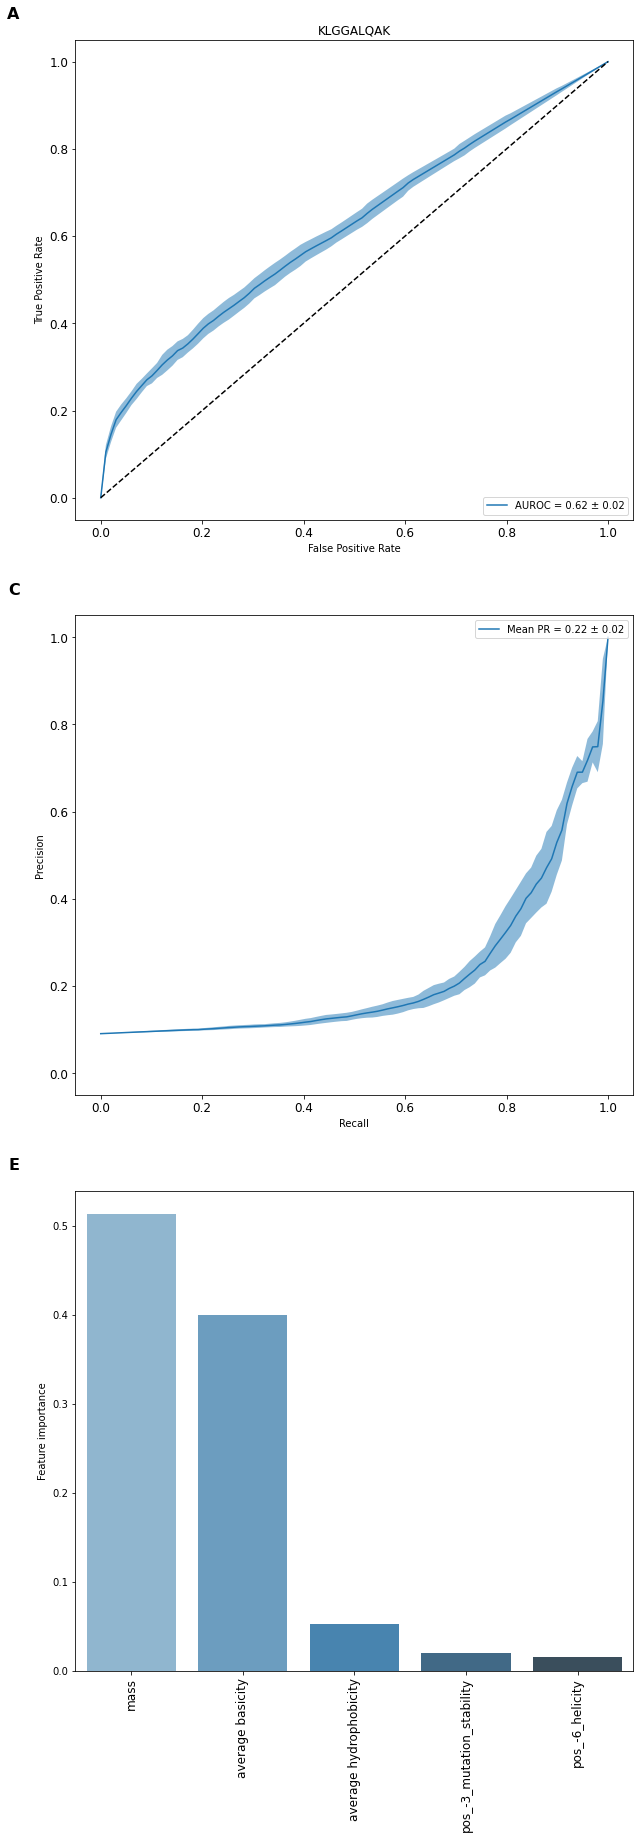

In [472]:
f, axes = plt.subplots(3, 1, figsize=(10, 30))

for i, (peptide, predictions, predictions_proba, feature_importances) in enumerate(peptide_predictions):
    # evaluate the performance of the prediction pipeline
    # accuracy (although not particularly useful for this unbalanced class problem)
    accuracy_mean = np.mean([metrics.accuracy_score(y_test, y_pred)
                             for y_test, y_pred in predictions])
    accuracy_std = np.std([metrics.accuracy_score(y_test, y_pred)
                           for y_test, y_pred in predictions])

    # AUC and average precision
    auc_mean = np.mean([metrics.roc_auc_score(y_test, y_pred)
                        for y_test, y_pred in predictions_proba])
    auc_std = np.std([metrics.roc_auc_score(y_test, y_pred)
                      for y_test, y_pred in predictions_proba])
    avg_precision_mean = np.mean([metrics.average_precision_score(y_test, y_pred)
                                  for y_test, y_pred in predictions_proba])
    avg_precision_std = np.std([metrics.average_precision_score(y_test, y_pred)
                                for y_test, y_pred in predictions_proba])
    avg_precision_inverted_mean = np.mean([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                           for y_test, y_pred in predictions_proba])
    avg_precision_inverted_std = np.std([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                         for y_test, y_pred in predictions_proba])

    # mean and standard deviation of ROC and precision-recall curves
    interval = np.linspace(0, 1, 100)
    tprs, precisions, precisions_inverted = [], [], []
    for y_test, y_pred in predictions_proba:
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
        tprs.append(np.interp(interval, fpr, tpr))

        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        precisions.append(np.interp(interval, recall[::-1], precision[::-1]))

        # inverted precision
        precision_inverted, recall_inverted, _ = metrics.precision_recall_curve(1 - y_test, 1 - y_pred)
        precisions_inverted.append(np.interp(interval, recall_inverted[::-1], precision_inverted[::-1]))

    tpr_mean = np.mean(tprs, axis=0)
    tpr_mean[0], tpr_mean[-1] = 0.0, 1.0
    tpr_std = np.std(tprs, axis=0)
    precision_mean = np.mean(precisions, axis=0)
    precision_std = np.std(precisions, axis=0)
    precision_inverted_mean = np.mean(precisions_inverted, axis=0)
    precision_inverted_std = np.std(precisions_inverted, axis=0)

    # print accuracy
    print('{} classification accuracy = {:.2%} ± {:.2%}'.format(peptide, accuracy_mean, accuracy_std))

    # plot ROC curve
    ax = axes[0]
    ax.plot(interval, tpr_mean, label='AUROC = {:.2f} ± {:.2f}'.format(auc_mean, auc_std))
    ax.fill_between(interval, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.5)

    ax.plot([0, 1], [0, 1], 'k--')
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title(peptide)

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    ax.legend(loc='lower right', frameon=True)
    
    ax.annotate(string.ascii_uppercase[i], xy=(-0.1,1.1), xycoords='axes fraction', textcoords='offset points',
                fontsize=16, xytext=(0, -15), weight='bold', ha='right', va='top')
    
    # plot precision-recall curve
    ax = axes[1]
    ax.plot(interval[::-1], precision_mean,
            label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_mean, avg_precision_std))
    ax.fill_between(interval[::-1], precision_mean - precision_std, precision_mean + precision_std, alpha=0.5)
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)
    
    ax.legend(loc='upper right', frameon=True)

    ax.annotate(string.ascii_uppercase[i + 2], xy=(-0.1,1.1), xycoords='axes fraction', textcoords='offset points',
                fontsize=16, xytext=(0, -15), weight='bold', ha='right', va='top')
    
    # plot feature importances
    ax = axes[2]
    feat_import_s = pd.Series(np.mean(feature_importances, axis=0),
                              index=feature_names, name='Feature importances')
    significant_features = feat_import_s[feat_import_s > 0.01].sort_values(ascending=False)

    sns.barplot(x=significant_features.index.values, y=significant_features, palette='Blues_d', ax=ax)

    ax.set_xticklabels(significant_features.index.values, rotation='vertical', fontsize=12)
    
    ax.set_ylabel('Feature importance')
    
    ax.annotate(string.ascii_uppercase[i + 4], xy=(-0.1,1.1), xycoords='axes fraction', textcoords='offset points',
                fontsize=16, xytext=(0, -15), weight='bold', ha='right', va='top')
    
plt.savefig('KLGGALQAK.pdf'.format(peptide), bbox_inches='tight', dpi=600)
plt.show()
plt.close()